In [ ]:
from google.colab import drive
# Mount Google Drive to access files
drive.mount('/content/drive')

In [78]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.express as px
from IPython.display import display
import os

In [119]:
base_directory = '/content/drive/MyDrive'
# Load dataset
print("\n1. Loading and Preparing Dataset...")
dataset_path = os.path.join(base_directory, 'FYP_Data_PipeLine/BTC_1h.csv')
maindf = pd.read_csv(dataset_path)
model_name = os.path.splitext(os.path.basename(dataset_path))[0]
print(f"\nModel Name: {model_name}")


1. Loading and Preparing Dataset...

Model Name: BTC_1h


In [102]:
print("\nDataset Overview:")
display(maindf.head())
print(f"\nDataset Shape: {maindf.shape}")
# Display dataset info
print("\nDataset Information:")
display(maindf.info())

# Display basic statistics
print("\nBasic Statistics:")
display(maindf.describe())

# Check for null values
print("\nNull Value Check:")
null_df = pd.DataFrame({
    'Column': maindf.columns,
    'Null Count': maindf.isnull().sum(),
    'Null Percentage': (maindf.isnull().sum() / len(maindf) * 100).round(2)
})
display(null_df)


Dataset Overview:


,Open Time,Open,High,Low,Close,Quote Asset Volume,Open Interest (USD),LSRatio,FearGreedIndex,TwitterIndex
0,2024-07-18 16:00:00,63500.1,63933.3,63206.4,63535.6,2.550647e+09,1.722490e+09,1.1867,61.0,50.0
1,2024-07-18 20:00:00,63535.5,64096.3,63413.1,63959.9,1.149184e+09,1.709425e+09,1.1925,61.0,50.0
2,2024-07-19 00:00:00,63960.0,64348.2,63266.2,64298.0,1.963878e+09,1.719133e+09,1.2257,60.0,50.0
3,2024-07-19 04:00:00,64297.9,64469.3,63565.0,63673.9,1.805593e+09,1.702468e+09,1.2178,60.0,50.0
4,2024-07-19 08:00:00,63673.9,64165.8,63371.4,64095.2,2.258746e+09,1.706867e+09,1.2060,60.0,50.0



Dataset Shape: (1104, 10)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Open Time            1104 non-null   object 
 1   Open                 1104 non-null   float64
 2   High                 1104 non-null   float64
 3   Low                  1104 non-null   float64
 4   Close                1104 non-null   float64
 5   Quote Asset Volume   1104 non-null   float64
 6   Open Interest (USD)  1104 non-null   float64
 7   LSRatio              1104 non-null   float64
 8   FearGreedIndex       1104 non-null   float64
 9   TwitterIndex         1104 non-null   float64
dtypes: float64(9), object(1)
memory usage: 86.4+ KB


None


Basic Statistics:


,Open,High,Low,Close,Quote Asset Volume,Open Interest (USD),LSRatio,FearGreedIndex,TwitterIndex
count,1104.000000,1104.000000,1104.000000,1104.000000,1.104000e+03,1.104000e+03,1104.000000,1104.000000,1104.0
mean,75725.639130,76326.849457,75125.772826,75762.714764,3.105423e+09,2.078622e+09,1.187980,60.405797,50.0
std,16679.499791,16820.451314,16556.399363,16697.947967,2.502820e+09,6.457053e+08,0.078832,19.558087,0.0
min,51316.700000,53200.000000,48888.000000,51316.800000,4.005516e+08,1.064247e+09,1.024300,17.000000,50.0
25%,61528.225000,61977.850000,60828.925000,61528.325000,1.437830e+09,1.574059e+09,1.124500,48.000000,50.0
50%,67530.100000,67988.300000,67097.500000,67547.100000,2.267377e+09,1.936817e+09,1.192250,69.000000,50.0
75%,94832.800000,95490.675000,94208.600000,94892.350000,3.941946e+09,2.507684e+09,1.249700,75.000000,50.0
max,106824.400000,108366.800000,106671.700000,106824.400000,1.635132e+10,3.877023e+09,1.353500,94.000000,50.0



Null Value Check:


,Column,Null Count,Null Percentage
Open Time,Open Time,0,0.0
Open,Open,0,0.0
High,High,0,0.0
Low,Low,0,0.0
Close,Close,0,0.0
Quote Asset Volume,Quote Asset Volume,0,0.0
Open Interest (USD),Open Interest (USD),0,0.0
LSRatio,LSRatio,0,0.0
FearGreedIndex,FearGreedIndex,0,0.0
TwitterIndex,TwitterIndex,0,0.0


In [103]:
# Select features
features = ['Open', 'High', 'Low', 'Close', 'Quote Asset Volume',
           'Open Interest (USD)', 'LSRatio', 'FearGreedIndex',
           'TwitterIndex']

print("\n2. Selected features:")
feature_df = pd.DataFrame({'Features': features})
display(feature_df)


2. Selected features:


,Features
0,Open
1,High
2,Low
3,Close
4,Quote Asset Volume
5,Open Interest (USD)
6,LSRatio
7,FearGreedIndex
8,TwitterIndex


In [104]:
# Create feature dataframe
closedf = maindf[['Open Time'] + features].copy()
closedf['Adj Close'] = maindf['Close']  # Target variable

print("\n3. Feature DataFrame Sample:")
display(closedf.head())


3. Feature DataFrame Sample:


,Open Time,Open,High,Low,Close,Quote Asset Volume,Open Interest (USD),LSRatio,FearGreedIndex,TwitterIndex,Adj Close
0,2024-07-18 16:00:00,63500.1,63933.3,63206.4,63535.6,2.550647e+09,1.722490e+09,1.1867,61.0,50.0,63535.6
1,2024-07-18 20:00:00,63535.5,64096.3,63413.1,63959.9,1.149184e+09,1.709425e+09,1.1925,61.0,50.0,63959.9
2,2024-07-19 00:00:00,63960.0,64348.2,63266.2,64298.0,1.963878e+09,1.719133e+09,1.2257,60.0,50.0,64298.0
3,2024-07-19 04:00:00,64297.9,64469.3,63565.0,63673.9,1.805593e+09,1.702468e+09,1.2178,60.0,50.0,63673.9
4,2024-07-19 08:00:00,63673.9,64165.8,63371.4,64095.2,2.258746e+09,1.706867e+09,1.2060,60.0,50.0,64095.2


In [105]:
# Convert Open Time to datetime
closedf['Open Time'] = pd.to_datetime(closedf['Open Time'])
print("\n4. Date Range:")
date_range = pd.DataFrame({
    'Start Date': [closedf['Open Time'].min()],
    'End Date': [closedf['Open Time'].max()]
})
display(date_range)


4. Date Range:


,Start Date,End Date
0,2024-07-18 16:00:00,2025-01-18 12:00:00


In [106]:
# Preserve columns
date_column = closedf['Open Time'].reset_index(drop=True)
close_stock = closedf[['Open Time', 'Adj Close']].copy()

# Prepare for scaling
del closedf['Open Time']

In [108]:
# Define the number of rows to display
num_rows_to_display_scaled = 10

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
closedf_scaled = scaler.fit_transform(closedf)

print(f"\n5. Scaled Data Sample (first {num_rows_to_display_scaled} rows):")
scaled_df = pd.DataFrame(closedf_scaled, columns=closedf.columns)
display(scaled_df.head(num_rows_to_display_scaled).round(4))



5. Scaled Data Sample (first 10 rows):


,Open,High,Low,Close,Quote Asset Volume,Open Interest (USD),LSRatio,FearGreedIndex,TwitterIndex,Adj Close
0,0.2195,0.1946,0.2478,0.2201,0.1348,0.2340,0.4933,0.5714,0.0,0.2201
1,0.2201,0.1975,0.2514,0.2278,0.0469,0.2294,0.5109,0.5714,0.0,0.2278
2,0.2278,0.2021,0.2488,0.2339,0.0980,0.2328,0.6118,0.5584,0.0,0.2339
3,0.2339,0.2043,0.2540,0.2226,0.0881,0.2269,0.5878,0.5584,0.0,0.2226
4,0.2226,0.1988,0.2506,0.2302,0.1165,0.2285,0.5519,0.5584,0.0,0.2302
5,0.2302,0.2297,0.2617,0.2608,0.3586,0.2379,0.4733,0.5584,0.0,0.2608
6,0.2608,0.2567,0.2924,0.2845,0.3779,0.2822,0.3821,0.5584,0.0,0.2845
7,0.2845,0.2560,0.3064,0.2758,0.0880,0.3348,0.3961,0.5584,0.0,0.2758
8,0.2758,0.2465,0.2989,0.2748,0.0681,0.3255,0.2907,0.7403,0.0,0.2748
9,0.2748,0.2452,0.3031,0.2740,0.0221,0.3232,0.3141,0.7403,0.0,0.2740


In [110]:
# Define the percentages
train_percentage = 0.70
test_percentage = 1 - train_percentage

# Calculate training and testing sizes
training_size = int(len(closedf_scaled) * train_percentage)
test_size = len(closedf_scaled) - training_size

# Split the data
train_data = closedf_scaled[0:training_size, :]
test_data = closedf_scaled[training_size:len(closedf_scaled), :]

print("\n6. Data Split Information:")
split_info = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Size': [train_data.shape[0], test_data.shape[0]],
    'Percentage': [train_percentage * 100, test_percentage * 100]
})
display(split_info)



6. Data Split Information:


,Dataset,Size,Percentage
0,Training,772,70.0
1,Testing,332,30.0


In [111]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        sequence = dataset[i:(i + time_step), :-1]
        dataX.append(sequence)
        next_close = dataset[i + time_step, -1]
        dataY.append(next_close)
    return np.array(dataX), np.array(dataY)

# Create time series datasets
time_step = 6
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("\n7. Dataset Shapes:")
shapes_df = pd.DataFrame({
    'Dataset': ['X_train', 'y_train', 'X_test', 'y_test'],
    'Shape': [str(X_train.shape), str(y_train.shape), str(X_test.shape), str(y_test.shape)]
})
display(shapes_df)


7. Dataset Shapes:


,Dataset,Shape
0,X_train,"(765, 6, 9)"
1,y_train,"(765,)"
2,X_test,"(325, 6, 9)"
3,y_test,"(325,)"


In [112]:
# Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(time_step, len(features)), activation="relu", return_sequences=True),
    LSTM(50, activation="relu"),
    Dense(25),
    Dense(1)
])
model.compile(loss="mean_squared_error", optimizer="adam")

print("\n8. Model Architecture:")
model.summary()


8. Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 6, 50)               │          12,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,501 (130.86 KB)

 Trainable params: 33,501 (130.86 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=200, batch_size=32, verbose=1)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0537 - val_loss: 0.0503
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - val_loss: 0.0172
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0179
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.9238e-04 - val_loss: 0.0126
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.3614e-04 - val_loss: 0.0096
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9746e-04 - val_loss: 0.0077
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2698e-04 - val_loss: 0.0064
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5148e-04 - val_loss: 0.0049
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0638e-04 - val_loss: 0.0034
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8845e-04 - val_loss: 0.0026
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3786e-04 - val_loss: 0.0022
Epoch 12/200
24/24 ━

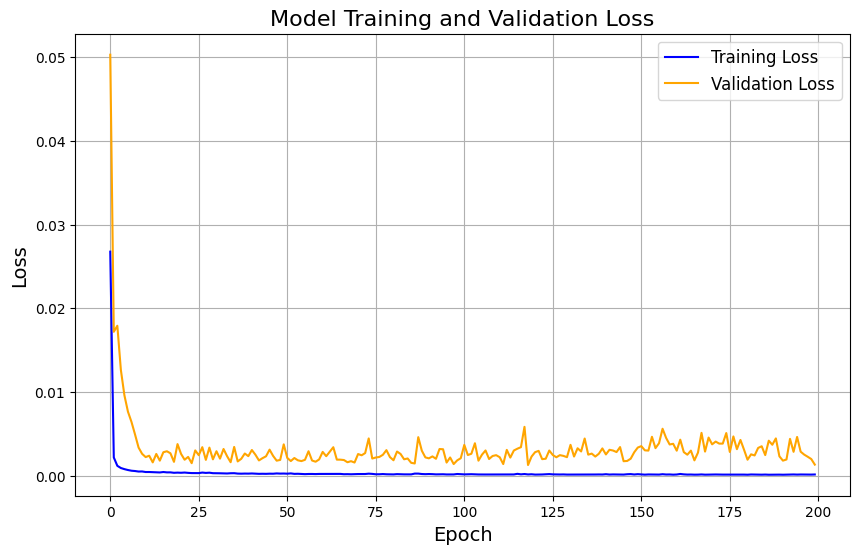

In [114]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [115]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [116]:
# Inverse transform predictions
train_predict_dummy = np.zeros((train_predict.shape[0], len(features) + 1))
test_predict_dummy = np.zeros((test_predict.shape[0], len(features) + 1))
train_predict_dummy[:, -1] = train_predict.flatten()
test_predict_dummy[:, -1] = test_predict.flatten()
train_predict = scaler.inverse_transform(train_predict_dummy)[:, -1]
test_predict = scaler.inverse_transform(test_predict_dummy)[:, -1]

# Prepare actual values
y_train_dummy = np.zeros((y_train.shape[0], len(features) + 1))
y_test_dummy = np.zeros((y_test.shape[0], len(features) + 1))
y_train_dummy[:, -1] = y_train
y_test_dummy[:, -1] = y_test
original_ytrain = scaler.inverse_transform(y_train_dummy)[:, -1]
original_ytest = scaler.inverse_transform(y_test_dummy)[:, -1]

print("\n10. Model Performance Metrics:")
metrics_train = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE %', 'R2', 'Explained Variance'],
    'Training': [
        math.sqrt(mean_squared_error(original_ytrain, train_predict)),
        mean_squared_error(original_ytrain, train_predict),
        mean_absolute_error(original_ytrain, train_predict),
        mean_absolute_percentage_error(original_ytrain, train_predict) * 100,
        r2_score(original_ytrain, train_predict),
        explained_variance_score(original_ytrain, train_predict)
    ]
})

metrics_test = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE %', 'R2', 'Explained Variance'],
    'Testing': [
        math.sqrt(mean_squared_error(original_ytest, test_predict)),
        mean_squared_error(original_ytest, test_predict),
        mean_absolute_error(original_ytest, test_predict),
        mean_absolute_percentage_error(original_ytest, test_predict) * 100,
        r2_score(original_ytest, test_predict),
        explained_variance_score(original_ytest, test_predict)
    ]
})

print("\nTraining Metrics:")
display(metrics_train.round(4))
print("\nTesting Metrics:")
display(metrics_test.round(4))


10. Model Performance Metrics:

Training Metrics:


,Metric,Training
0,RMSE,934.1959
1,MSE,872721.9844
2,MAE,743.6438
3,MAPE %,1.0909
4,R2,0.9913
5,Explained Variance,0.9950



Testing Metrics:


,Metric,Testing
0,RMSE,2.035418e+03
1,MSE,4.142924e+06
2,MAE,1.693692e+03
3,MAPE %,1.734300e+00
4,R2,6.277000e-01
5,Explained Variance,6.662000e-01


In [117]:
# Define the number of rows to display
num_rows_to_display = 10
# Create comparison table
comparison_table = pd.DataFrame({
    'Date': date_column[training_size+time_step:-1].reset_index(drop=True)[-len(test_predict):],
    'Predicted Close': test_predict,
    'Actual Close': original_ytest,
    'Difference': abs(test_predict - original_ytest),
    'Difference %': (abs(test_predict - original_ytest) / original_ytest) * 100
})

# Print the comparison table
print(f"\n11. Prediction Comparison (First {num_rows_to_display} rows):")
display(comparison_table.head(num_rows_to_display).round(2))



11. Prediction Comparison (First 10 rows):


,Date,Predicted Close,Actual Close,Difference,Difference %
0,2024-11-25 08:00:00,99561.79,98268.0,1293.79,1.32
1,2024-11-25 12:00:00,99723.10,96040.4,3682.70,3.83
2,2024-11-25 16:00:00,98790.40,94723.6,4066.80,4.29
3,2024-11-25 20:00:00,96928.55,93064.0,3864.55,4.15
4,2024-11-26 00:00:00,95614.60,94537.8,1076.80,1.14
5,2024-11-26 04:00:00,95593.20,93842.1,1751.10,1.87
6,2024-11-26 08:00:00,95429.88,92420.0,3009.88,3.26
7,2024-11-26 12:00:00,94312.32,92877.4,1434.92,1.54
8,2024-11-26 16:00:00,94386.88,91760.0,2626.88,2.86
9,2024-11-26 20:00:00,93989.19,92021.4,1967.79,2.14


In [118]:
# Create visualization
def plot_predictions(close_stock, train_predict, test_predict, date_column, time_step):
    trainPredictPlot = np.empty((len(close_stock), 1))
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step:len(train_predict)+time_step, 0] = train_predict

    testPredictPlot = np.empty((len(close_stock), 1))
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_step*2)+1:len(close_stock)-1, 0] = test_predict

    plotdf = pd.DataFrame({
        'Date': close_stock['Open Time'],
        'Original Close': close_stock['Adj Close'],
        'Train Predicted Close': trainPredictPlot.flatten(),
        'Test Predicted Close': testPredictPlot.flatten()
    })

    fig = px.line(plotdf, x='Date',
                  y=['Original Close', 'Train Predicted Close', 'Test Predicted Close'],
                  title='Original vs Predicted Close Price')
    fig.show()

plot_predictions(close_stock, train_predict, test_predict, date_column, time_step)


In [98]:
model_save_directory = os.path.join(base_directory, 'FYP_Model_PipeLine')
model_save_path = os.path.join(model_save_directory, f"{model_name}.h5")  # Constructs the full save path
# Save the model
model.save(model_save_path)
print(f"\nModel saved successfully at: {model_save_path}")


Model saved successfully at: /content/drive/MyDrive/FYP_Model_PipeLine/BTC_1d.h5
